<a href="https://colab.research.google.com/github/josesg998/Calculadora_fechas_vencimiento/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import polars as pl
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import numpy as np
from concurrent.futures import ThreadPoolExecutor

from torchvision import transforms, datasets

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import no_grad, max, zeros, device, optim, nn, Generator, stack, long
import torch
import torch.nn.functional as F

In [2]:
# Download latest version
path = kagglehub.dataset_download("ahmedxc4/parasite-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ahmedxc4/parasite-dataset/versions/1


In [3]:
#movemos las tres carpetas a content
ruta_origen = path
# ruta main de colab
ruta_destino = '/content'

try:
  shutil.move(os.path.join(ruta_origen, 'parasite-dataset'), os.path.join(ruta_destino, 'parasite-dataset'))
except:
  print("Ya se movió la carpeta a /content")

Ya se movió la carpeta a /content


In [4]:
folders = os.listdir('parasite-dataset')
folders.remove('README.md')

def process_image(ruta_completa):
    try:
        imagen = Image.open(ruta_completa)
        ancho, alto = imagen.size
        return ancho, alto
    except OSError:
        return None

def measure_means_folder():
    metricas = {}
    for folder in folders:
        print(folder)
        metricas[folder] = {}

        # Inicializar variables para calcular la media del tamaño de las imágenes
        total_imagenes = 0
        suma_ancho = 0
        suma_alto = 0

        # Inicializar variable para contar imágenes en distintos rangos de tamaño
        rangos_tamano = {
            '0-100x0-100': 0,
            '101-200x101-200': 0,
            '201-300x201-300': 0,
            '301-infx301-inf': 0
        }

        directorio = os.path.join('parasite-dataset', folder)
        archivos = [os.path.join(directorio, archivo) for archivo in os.listdir(directorio) if archivo.endswith(('.png', '.jpg', '.jpeg'))]

        with ThreadPoolExecutor() as executor:
            results = executor.map(process_image, archivos)

        for result in results:
            if result:
                ancho, alto = result
                total_imagenes += 1
                suma_ancho += ancho
                suma_alto += alto

                if ancho <= 100 and alto <= 100:
                    rangos_tamano['0-100x0-100'] += 1
                elif ancho <= 200 and alto <= 200:
                    rangos_tamano['101-200x101-200'] += 1
                elif ancho <= 300 and alto <= 300:
                    rangos_tamano['201-300x201-300'] += 1
                else:
                    rangos_tamano['301-infx301-inf'] += 1

        # Calculate means and store in metricas
        if total_imagenes > 0:
            metricas[folder]['mean_width'] = suma_ancho / total_imagenes
            metricas[folder]['mean_height'] = suma_alto / total_imagenes
            metricas[folder]['total_images'] = total_imagenes

            for rango, cantidad in rangos_tamano.items():
                metricas[folder][rango] = cantidad

    return metricas

In [5]:
metricas = measure_means_folder()

RBCs
Toxoplasma
Plasmodium
Trichomonad
Leukocyte
Babesia
Trypanosome
Leishmania


In [6]:
metricas_df = pl.DataFrame()
for key in metricas.keys():
    row_df = pl.DataFrame(metricas[key])
    row_df = row_df.with_columns(folder=pl.lit(key))
    # put folder column in the first position
    row_df = row_df.select(['folder','total_images' ,'mean_width', 'mean_height', '0-100x0-100', '101-200x101-200', '201-300x201-300', '301-infx301-inf'])
    #split size_ranges into separate columns
    metricas_df = metricas_df.vstack(row_df)

metricas_df = metricas_df.sort('total_images', descending=False)
metricas_df

folder,total_images,mean_width,mean_height,0-100x0-100,101-200x101-200,201-300x201-300,301-infx301-inf
str,i64,f64,f64,i64,i64,i64,i64
"""Plasmodium""",843,180.177936,176.512456,52,480,311,0
"""Babesia""",1173,233.520887,226.636829,0,111,987,75
"""Leukocyte""",1376,80.898256,82.207849,1194,74,32,76
"""Trypanosome""",2385,204.614675,199.615514,1117,233,17,1018
"""Leishmania""",2701,366.273973,351.644946,0,29,241,2431
"""Toxoplasma""",6691,59.040801,59.121955,4682,1959,50,0
"""RBCs""",8995,190.651695,187.4408,610,3473,4884,28
"""Trichomonad""",10134,374.167061,360.032169,0,11,744,9379


In [7]:
# plot the counts as horizontal barchart with plt
#plt.figure(figsize=(10, 5))
#plt.barh(metricas_df['folder'], metricas_df['total_images'])
#plt.title('Conteo de imágenes por carpeta')
#plt.xlabel('conteo')
#plt.ylabel('especie')
#plt.show()

In [8]:
def train_test_val(folder='parasite-dataset'):
  # Define the transformations for the dataset
  transform_first = transforms.Compose([
        transforms.Resize((32, 32))
        ,transforms.ToTensor()
    ])

     # Create the dataset object
  dataset = datasets.ImageFolder(root=folder,transform=transform_first)

  # Define the split ratio (e.g., 80% train, 20% test)
  train_ratio = 0.8
  test_ratio = 1 - train_ratio

  # Calculate the number of samples for each split
  train_size = int(len(dataset) * train_ratio)
  test_size = len(dataset) - train_size
  val_size = int((train_size - test_size)*.2)
  train_size = train_size-val_size

  # Split the dataset into train and test sets
  train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size,val_size], generator=Generator().manual_seed(42))

  print(f"Train dataset size: {len(train_dataset):_}")
  print(f"Test dataset size: {len(test_dataset):_}")
  print(f"Validation dataset size: {len(val_dataset):_}")

  return train_dataset, test_dataset, val_dataset

In [9]:
train_dataset, test_dataset, val_dataset = train_test_val()

# Calcular media y desviación estándar de los tres canales (train dataset)
n_classes = 2

imgs = stack([img_t for img_t, label in train_dataset if (label<n_classes)], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)


print(f'Media: {mean}')
print(f'Desviación estándar: {std}')

Train dataset size: 23_323
Test dataset size: 6_860
Validation dataset size: 4_115
Media: tensor([0.5861, 0.5253, 0.6174])
Desviación estándar: tensor([0.1059, 0.1092, 0.0927])


In [10]:
class TrainDataset(Dataset):

  def __init__(self, partition, mean, std,n_classes):
    '''
    Constructor de la clase. Podemos pasarle todos los parámetros que querramos,
    en este caso usamos:
    - partition: si es 'training' o 'validation'
    - mean: la media que vamos a usar para normalizar los datos
    - std: el desvío estándar
    '''

    # usamos siempre el constructor de la clase madre primero, por las dudas que
    # inicialice cosas que nosotros no sepamos
    super(TrainDataset, self).__init__()

    # hacemos un chequeo de que no entre cualquier cosa en vez de partition
    assert partition in ['training', 'validation','test'], 'partition has to be training or validation, not {}'.format(partition)

    # armamos las transformaciones que tenemos que aplicarle a los datos,
    # incluyendo la normalización

    if partition =='training':

      # Define the transformations for the dataset
      transform_train = transforms.Compose([
          transforms.Resize((32, 32)),
          # Definir las transformaciones de aumento
          #transforms.RandomRotation(40),
          #transforms.RandomAffine(degrees=0, shear=0.2),
          #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
          #transforms.RandomHorizontalFlip(),
          #transforms.ColorJitter(brightness=(0.5, 1.5)),
          transforms.ToTensor()
          ,transforms.Normalize(mean=mean, std=std)
      ])

      dataset_f = train_dataset

      dataset_f.transform = transform_train

    elif partition=='validation':
      # Define the transformations for the dataset
      transform_val = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ,transforms.Normalize(mean=mean, std=std)
      ])

      #dataset_f = val_dataset
      dataset_f = val_dataset
      dataset_f.transform = transform_val

    else:
      # Define the transformations for the dataset
      transform_test = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ,transforms.Normalize(mean=mean, std=std)
      ])

      #dataset_f = val_dataset
      dataset_f = test_dataset
      dataset_f.transform = transform_test


    labels = [n for n in range(n_classes)]

    # hacemos una lista de nombres para las clases
    self.class_names = dataset_f.dataset.classes[:n_classes]

    self.data = [(img,label) for img,label in dataset_f if label in labels]

  def __len__(self):
    '''
    Método que te devuelve la cantidad de elementos del dataset
    '''
    # simplemente devolvemos la longitud de la lista
    return len(self.data)


  def __getitem__(self, index):
    '''
    Método que te devuelve el elemento index del dataset
    '''
    # obtenemos la imagen y su etiqueta asociada
    img, label = self.data[index]
    # convertimos la etiqueta en un tensor de tipo long
    tensor_label = torch.zeros(1)
    tensor_label[0] = label
    label = tensor_label.long()
    # retornamos el par
    return (img, label)

In [11]:
from torch import nn
class ParasiteFullyConnectedNN(nn.Module):
  '''
  Clase que implementa una arquitectura fully connected de 2 capas para
  resolver el problema de clasificar aviones y pájaros
  '''

  def __init__(self):
    '''
    Constructor: crea la arquitectura
    '''

    # siempre llamamos al constructor de la clase madre primero
    super(ParasiteFullyConnectedNN, self).__init__()
    # número de salidas del modelo (probabilidades de ser avión o pájaro)
    n_out = 2

    self.model = nn.Sequential(
        # una capa fully connected
        nn.Linear(3072, # cantidad de features en la entrada: 32 x 32 x 3 colores
                  512),  # tamaño de la hidden layer
        # una función de activación (la tangente hiperbólica)
        nn.Tanh(),
        # otra capa fully connected
        nn.Linear(512, # tamaño de la hidden layer
                  n_out), # cantidad de clases en la salida,
        # la función de activación para las salidas, que las hace probabilidades
        nn.Softmax(dim=1)
    )

      # agregamos la función de activación como un atributo
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, inputs):
    '''
    Método que implementa el forward pass
    '''
    return self.model(inputs)

  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.model(inputs))

In [12]:
import torch.nn.functional as F

class ParasiteCNN(nn.Module):
  '''
  Una primera red neuronal convolucional
  '''

  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()

    # vamos a plantear un modelo con 2 capas convolucionales, una que produce
    # 8 activations maps
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
    # y otro que produce 16 activations maps a partir de los 8 anteriores
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

    # las imágenes de 32 x 32 x 3 bajarán de tamaño 2 veces usando maxpooling de 2x2,
    # llegando a un tamaño de 8x8 x 16 activation maps.

    # con eso alimentamos la capa fully connected, que va a generarnos 32 features
    # combinando esas que generamos antes
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    # y de esas 32 features generaremos 2 scores
    self.fc2 = nn.Linear(32, 2)
    # que pasaremos por la capa softmax para obtener probabilidades
    self.final_activation = nn.Softmax(dim=1)


  def forward(self, x):
    '''
    Método que implementa el forward pass
    '''

    # aplicamos la convolución, sobre ella la función de activación, y después
    # el maxpooling con un kernel_size de 2x2
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    # a esa salida la pasamos por la segunda convolución, otra función de activación,
    # y nuevamente el maxpooling con kernel de 2x2
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    # ahora convertimos el activamos map en un vector
    out = out.view(-1, 8 * 8 * 16)
    # que pasamos por la primera capa fully connected y por la función de activación
    out = torch.tanh(self.fc1(out))
    # y después por la última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.__call__(inputs))

In [13]:
# creamos una instancia de nuestro training set
training_set = TrainDataset('training', mean, std,n_classes=n_classes)
# creamos un dataloader para los datos de training
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)

# creamos una instancia de nuestro validation set
validation_set = TrainDataset('validation', mean, std,n_classes=n_classes)
# creamos un dataloader para los datos de validation
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)

In [14]:
# inicializamos la función de pérdida
loss_fn = nn.CrossEntropyLoss()
# creamos una nueva instancia de la red
fc_model = ParasiteFullyConnectedNN()

In [15]:
i = 0
# recorremos por 2 iteraciones nuestro dataset de entrenamiento
for imgs, labels in training_loader:
  # imprimiendo el tamaño del batch de imágenes y el de etiquetas
  print('Image batch size: {}'.format(imgs.shape))
  print('Labels batch size: {}'.format(labels.shape))
  print('')
  i=i+1
  if i==2:
    break

Image batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64, 1])

Image batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64, 1])



In [16]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, validation_loader, device, is_fully_connected=False):

  # inicializamos una lista de valores de loss por época
  training_loss_per_epoch = []
  validation_loss_per_epoch = []
  # e igual del accuracy
  training_accuracy_per_epoch = []
  validation_accuracy_per_epoch = []

  # iteramos por cada época
  for epoch in range(1, n_epochs + 1):

    # -----------------------------
    #          TRAINING
    # -----------------------------

    # inicializamos el valor de la loss en 0
    loss_train = 0.0
    # y la cantidad de valores totales y correctos (para calcular accuracy)
    total = 0
    correct = 0
    model.train()
    # for cada batch en nuestros datos de entrenamiento
    for imgs, labels in train_loader:

      # si la red es fully connected, acomodamos las imágenes al formato de entrada de la red
      if is_fully_connected:
        batch_size = imgs.shape[0]
        imgs = imgs.view(batch_size, -1)

      # pasamos imágenes y etiquetas a GPU
      imgs = imgs.to(device=device)
      labels = torch.squeeze(labels)
      labels = labels.to(device=device)
      # hacemos un forward pass
      outputs = model(imgs)

      # evaluamos la loss
      loss = loss_fn(outputs, labels)
      # limpiamos los gradientes anteriores
      optimizer.zero_grad()
      # calculamos los gradientes con backpropagation
      loss.backward()
      # actualizamos el optimizador
      optimizer.step()
      # y vamos sumando los valores de la loss
      loss_train += loss.item()

      # también podemos calcular el accuracy sobre datos de entrenamiento:
      # primero tenemos que estimar las etiquetas
      _, predicted = torch.max(model.final_activation(outputs), dim=1)
      # y después calculamos total de muestras y correctas
      total += labels.shape[0]
      correct += int((predicted == labels).sum())

    # calculamos el promedio de la loss por época
    training_loss_per_epoch.append(loss_train / len(train_loader))
    # y el valor de accuracy
    training_accuracy_per_epoch.append(correct / total)

    # -----------------------------
    #         VALIDATION
    # -----------------------------

    # inicializamos el valor de la loss en 0
    loss_val = 0.0
    # y la cantidad de valores totales y correctos (para calcular accuracy)
    total = 0
    correct = 0
    model.eval()

    # como iteramos sobre los datos de validación, no calculamos gradientes
    with torch.no_grad():

      # for cada batch en nuestros datos de validación
      for imgs, labels in validation_loader:

        # si la red es fully connected, acomodamos las imágenes al formato de entrada de la red
        if is_fully_connected:
          batch_size = imgs.shape[0]
          imgs = imgs.view(batch_size, -1)

        # pasamos imágenes y etiquetas a GPU
        imgs = imgs.to(device=device)
        labels = torch.squeeze(labels)
        labels = labels.to(device=device)
        # hacemos un forward pass
        outputs = model(imgs)

        # evaluamos la loss
        loss = loss_fn(outputs, labels)
        # y vamos sumando sus valores
        loss_val += loss.item()

        # estimamos las etiquetas
        _, predicted = torch.max(model.final_activation(outputs), dim=1)
        # y calculamos total de muestras y correctas
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    # calculamos el promedio de la loss por época
    validation_loss_per_epoch.append(loss_val / len(validation_loader))
    # y el valor de accuracy
    validation_accuracy_per_epoch.append(correct / total)

    # -----------------------------
    #    IMPRIMIMOS RESULTADOS
    # -----------------------------

    # cada 10 épocas, mostramos cuánto tardó la época y qué valor obtuvimos
    if epoch == 1 or epoch % 10 == 0:
      print('Epoch {}:'.format(epoch),end='\r')
    #  print(' ---> Loss: Training {:.4f} - Validation {:.4f}'.format(training_loss_per_epoch[-1], validation_loss_per_epoch[-1]))
    #  print(' ---> Accuracy: Training {:.4f} - Validation {:.4f}'.format(training_accuracy_per_epoch[-1], validation_accuracy_per_epoch[-1]))

  # devolvemos los resultados
  return model, training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch

In [17]:
def plot_training_statistics(training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch):
  '''
  Plotea las estadísticas sobre datos de entrenamiento y validación
  (loss function y valores de accuracy)
  '''

  # creamos plots para la loss y el accuracy
  fig, axes = plt.subplots(1, 2)
  # graficamos la evolución de la loss de entrenamiento y la de validación
  axes[0].plot(training_loss_per_epoch, color='blue')
  axes[0].plot(validation_loss_per_epoch, color='red')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Cross entropy loss')
  axes[0].grid(True)
  axes[0].legend(['Training set', 'Validation set'])
  axes[0].set_title('Loss function')
  # graficamos la evolución del accuracy en los datos de entrenamiento y validación
  axes[1].plot(training_accuracy_per_epoch, color='blue')
  axes[1].plot(validation_accuracy_per_epoch, color='red')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].grid(True)
  axes[1].legend(['Training set', 'Validation set'])
  axes[1].set_title('Accuracy')
  axes[1].set_ylim([0, 1.0])
  fig.tight_layout(pad=3.0)

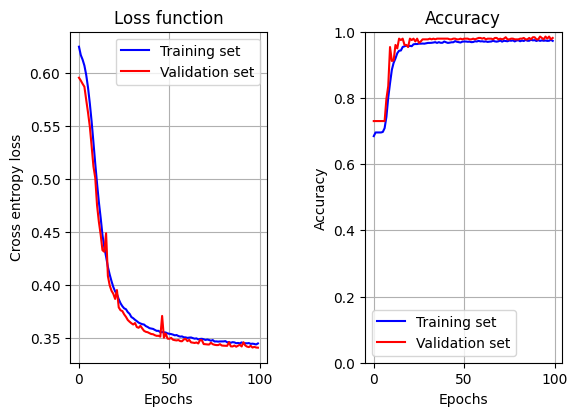

In [18]:
# elijan si quieren usarla o no, para ver la diferencia de performance!
use_gpu = True
# elegimos si usamos cuda o cpu
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# creamos una instancia del modelo
fc_model = ParasiteFullyConnectedNN()
# creamos la loss function
loss_fn = nn.CrossEntropyLoss()
# movemos todo lo que haga falta al dispositivo que hayamos elegido
fc_model = fc_model.to(device)
loss_fn = loss_fn.to(device)
# inicializamos un valor de learning rate
learning_rate = 1e-2
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.SGD(fc_model.parameters(), lr=learning_rate)
# determinamos el número de épocas por el que queremos entrenar
n_epochs = 100

# entrenamos la red, indicando que es fully connected
fc_model, tr_loss, val_loss, tr_acc, val_acc = training_loop(n_epochs, optimizer, fc_model, loss_fn, training_loader, validation_loader, device, is_fully_connected=True)

# ploteamos los resultados
plot_training_statistics(tr_loss, val_loss, tr_acc, val_acc)

In [19]:
# creamos una instancia del modelo
#cnn_model = ParasiteCNN()
# movemos el modelo a la GPU
#cnn_model = cnn_model.to(device)
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar (que la definimos arriba)
#optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)

# entrenamos la red, indicando que es fully connected y usando los mismos parámetros que antes
#cnn_model, tr_loss, val_loss, tr_acc, val_acc = training_loop(n_epochs, optimizer, cnn_model, loss_fn, training_loader, validation_loader, device, is_fully_connected=False)

# ploteamos los resultados
#plot_training_statistics(tr_loss, val_loss, tr_acc, val_acc)

In [34]:
# inicializamos el tamaño de batch
batch_size = 64

# ponemos el modelo en modo evaluación
fc_model.eval()

# creamos una instancia de nuestro test set
cifar_test_set = TrainDataset('test', mean, std,n_classes=2)
# creamos un dataloader para los datos de test
test_loader = DataLoader(cifar_test_set, batch_size=batch_size, shuffle=False)

# inicializamos matrices y arreglos para guardar:
# - probabilidades
probabilities = np.zeros((len(cifar_test_set), 2))
# - predicciones
predictions = np.zeros(len(cifar_test_set))
# - labels
labels = np.zeros(len(cifar_test_set))

# sin calcular el gradiente...
with no_grad():

  # inicializamos un contador de muestras
  num_samples = 0
  # iteramos por cada batch de test
  for i, (imgs, lbl) in enumerate(test_loader):

    # acomodamos las imágenes al formato de entrada de la red
    num_outputs = imgs.shape[0]
    imgs = imgs.view(num_outputs, -1)
    # actualizamos la cantidad de muestras que vamos llevando
    num_samples = num_samples + num_outputs

    # obtenemos las predicciones
    probs = fc_model.predict(imgs.cuda())
    # pasamos la salida a CPU
    probs = probs.cpu()
    # y recuperamos la clase más probable
    _, predicted = max(probs, dim=1)

    # colocamos las probabilidades, predicciones y etiquetas en los arreglos
    probabilities[i*batch_size : i*batch_size+num_outputs, :] = probs.numpy()
    predictions[i*batch_size : i*batch_size+num_outputs] = predicted.numpy()
    labels[i*batch_size : i*batch_size+num_outputs] = lbl.view(-1)

In [35]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels, predictions)
print("Confusion matrix:")
print(conf_mat)

Confusion matrix:
[[231  16]
 [  5 527]]


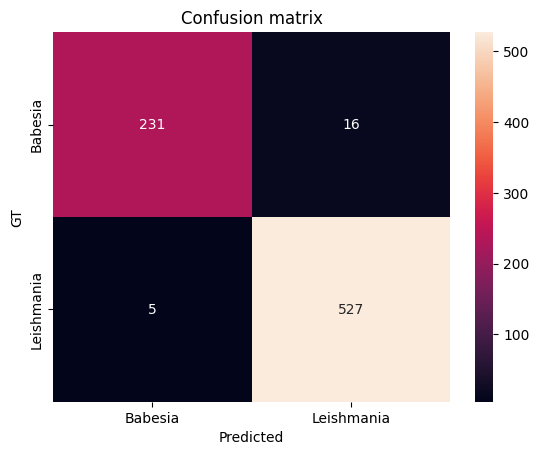

In [38]:
# importamos pandas
from pandas import crosstab, DataFrame
# y seaborn
import seaborn as sn

# generamos un dataframe de dos columnas con las etiquetas en la columna GT
# y las predicciones en la columna Predicted
df = DataFrame({'GT': labels, 'Predicted': predictions}, columns=['GT','Predicted'])
# obtenemos la matriz de confusión
conf_mat = crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
# la representamos graficamente con Seaborn
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True, fmt="d")
ax.set_title("Confusion matrix")
ax.set_xticklabels(training_set.class_names)
ax.set_yticklabels(training_set.class_names)
plt.show()